In [20]:
pip install opencv-python



  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/c7/ec/9dabb6a9abfdebb3c45b0cc52dec901caafef2b2c7e7d6a839ed86d81e91/opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.6 MB 1.3 MB/s eta 0:00:30
   ---------------------------------------- 0.4/38.6 MB 3.7 MB/s eta 0:00:11
    --------------------------------------- 0.7/38.6 MB 5.2 MB/s eta 0:00:08
   - -------------------------------------- 1.4/38.6 MB 7.6 MB/s eta 0:00:05
   - -------------------------------------- 1.8/38.6 MB 7.7 MB/s eta 0:00:05
   -- ------------------------------------- 2.5/38.6 MB 8.8 MB/s eta 0:00:05
   -- ------------------------------------- 2.7/38.6 MB 8.1 MB/s eta 0:00:05
   --- ------------------------------------ 3.0/38.6 MB 7.7 MB/s eta 0:00:05
   --- ---------------

In [24]:
pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/e5/18/3dfcce4effbd89b53

In [21]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, concatenate, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import os
import cv2

## 1: Cargar el DataFrame

In [2]:
# Ruta al archivo CSV
archivo_csv = 'df_BUENO_ID.csv'  
df_bueno = pd.read_csv(archivo_csv)


In [3]:
# Mostrar las primeras filas para confirmar que se cargó correctamente
df_bueno.head()

,Unnamed: 0,id_image,Price,Beds,Baths,Square Feet,Street,City,COUNTY,average_listing_price
0,0,2200 Sacramento St APT 206,1720000.0,2,2,969.0,2200 Sacramento St APT 206,SAN FRANCISCO,SAN FRANCISCO,1.939.987
1,1,114 10th Ave,1850000.0,3,2,2181.0,114 10th Ave,SAN FRANCISCO,SAN FRANCISCO,1.939.987
2,2,1982 44th Ave,1450000.0,3,2,1150.0,1982 44th Ave,SAN FRANCISCO,SAN FRANCISCO,1.939.987
3,3,2731 41st Ave,1310000.0,2,1,1012.0,2731 41st Ave,SAN FRANCISCO,SAN FRANCISCO,1.939.987
4,4,216 Dorland St,1360000.0,2,2,1132.0,216 Dorland St,SAN FRANCISCO,SAN FRANCISCO,1.939.987


## EDA

### Análisis de Datos Tabulares

In [4]:
df_bueno.shape

(321, 10)

In [5]:
df_bueno.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             321 non-null    int64  
 1   id_image               321 non-null    object 
 2   Price                  321 non-null    float64
 3   Beds                   321 non-null    int64  
 4   Baths                  321 non-null    int64  
 5   Square Feet            321 non-null    float64
 6   Street                 321 non-null    object 
 7   City                   321 non-null    object 
 8   COUNTY                 321 non-null    object 
 9   average_listing_price  321 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 25.2+ KB


La columna Price y average_listing_price están en formato object, lo cual quiere decir que se están tratando como cadenas de texto en lugar de números.

### Primero, vamos a asegurarnos de que las comas (si las hay) se eliminen, y los puntos decimales se manejen correctamente

In [6]:
# Para 'price'
df_bueno['Price'] = df_bueno['Price'].replace({'\$': '', ',': '', '\.': ''}, regex=True).astype(float)

In [7]:
# Para 'median_listing_price'
df_bueno['average_listing_price'] = df_bueno['average_listing_price'].replace({'\$': '', ',': '', '\.': ''}, regex=True).astype(float)

In [8]:
# A continuación, convertimos las columnas a numérico utilizando pd.to_numeric() por si acaso hay valores que no se han limpiado correctamente
df_bueno['Price'] = pd.to_numeric(df_bueno['Price'], errors='coerce')
df_bueno['average_listing_price'] = pd.to_numeric(df_bueno['average_listing_price'], errors='coerce')

Comprobamos

In [9]:
df_bueno.dtypes

Unnamed: 0                 int64
id_image                  object
Price                    float64
Beds                       int64
Baths                      int64
Square Feet              float64
Street                    object
City                      object
COUNTY                    object
average_listing_price    float64
dtype: object

Revisamos si hay valores NaN en las columnas Price y median_listing_price, después de la conversión-

In [10]:
df_bueno.isnull().sum()

Unnamed: 0               0
id_image                 0
Price                    0
Beds                     0
Baths                    0
Square Feet              0
Street                   0
City                     0
COUNTY                   0
average_listing_price    0
dtype: int64

Eliminamos la columna Unnamed: 0, porque no es relevante para el análisis.

In [11]:
df_bueno.drop(columns=['Unnamed: 0'], inplace=True)

In [12]:
df_bueno

,id_image,Price,Beds,Baths,Square Feet,Street,City,COUNTY,average_listing_price
0,2200 Sacramento St APT 206,1720000.0,2,2,969.0,2200 Sacramento St APT 206,SAN FRANCISCO,SAN FRANCISCO,1939987.0
1,114 10th Ave,1850000.0,3,2,2181.0,114 10th Ave,SAN FRANCISCO,SAN FRANCISCO,1939987.0
2,1982 44th Ave,1450000.0,3,2,1150.0,1982 44th Ave,SAN FRANCISCO,SAN FRANCISCO,1939987.0
3,2731 41st Ave,1310000.0,2,1,1012.0,2731 41st Ave,SAN FRANCISCO,SAN FRANCISCO,1939987.0
4,216 Dorland St,1360000.0,2,2,1132.0,216 Dorland St,SAN FRANCISCO,SAN FRANCISCO,1939987.0
...,...,...,...,...,...,...,...,...,...
316,2232 Daladier Dr,1680000.0,4,3,2948.0,2232 Daladier Dr,RANCHO PALOS VERDES,LOS ANGELES,2606021.0
317,27989 Beechgate Dr,1550000.0,4,3,2390.0,27989 Beechgate Dr,RANCHO PALOS VERDES,LOS ANGELES,2606021.0
318,13218 La Jolla Cir UNIT C,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,LA MIRADA,LOS ANGELES,2606021.0
319,14348 Flomar Dr,745000.0,2,2,1479.0,14348 Flomar Dr,WHITTIER,LOS ANGELES,2606021.0


### Descripción estádistica

In [13]:
df_bueno.describe()

,Price,Beds,Baths,Square Feet,average_listing_price
count,3.210000e+02,321.000000,321.000000,321.000000,3.210000e+02
mean,1.053946e+06,3.190031,2.445483,1829.464174,1.861715e+06
std,7.270849e+05,0.960807,0.882638,774.998693,9.304806e+05
min,4.100000e+03,1.000000,1.000000,572.000000,4.923580e+05
25%,5.800000e+05,3.000000,2.000000,1277.000000,9.433480e+05
50%,8.200000e+05,3.000000,2.000000,1689.000000,1.834937e+06
75%,1.400000e+06,4.000000,3.000000,2103.000000,2.606021e+06
max,4.950000e+06,8.000000,6.000000,5173.000000,5.009413e+06


Vamos a identificar porque en la columna de Price apaarecen valores tan extremos.

## 1. Identificar los valores extremos 

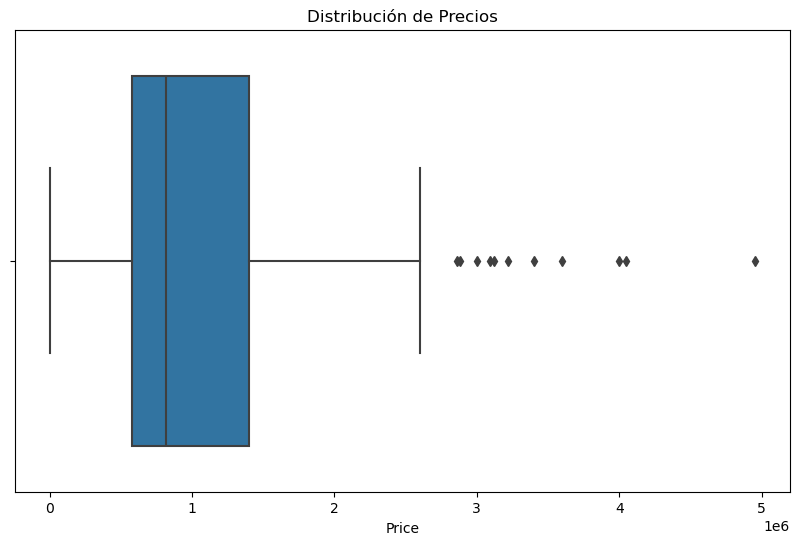

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_bueno['Price'])
plt.title('Distribución de Precios')
plt.show()

Si entramos en detalle, utilizando el rango intercuartílico (IQR)

In [15]:
Q1 = df_bueno['Price'].quantile(0.25)
Q3 = df_bueno['Price'].quantile(0.75)
IQR = Q3 - Q1
umbral_inferior = Q1 - 1.5 * IQR
umbral_superior = Q3 + 1.5 * IQR

outliers = df_bueno[(df_bueno['Price'] < umbral_inferior) | (df_bueno['Price'] > umbral_superior)]
print(f"Se encontraron {len(outliers)} outliers en la columna 'Price'.")


Se encontraron 11 outliers en la columna 'Price'.


Vamos a identificar que filas son:

In [16]:
outliers

,id_image,Price,Beds,Baths,Square Feet,Street,City,COUNTY,average_listing_price
24,1306 Rainbow Dr,3090000.0,4,3,2670.0,1306 Rainbow Dr,SAN MATEO,SAN MATEO,3157364.0
47,1740 La Coronilla Dr,2880000.0,3,2,1774.0,1740 La Coronilla Dr,SANTA BARBARA,SANTA BARBARA,5009413.0
211,692 Vanderbilt Dr,2860000.0,4,3,1990.0,692 Vanderbilt Dr,SUNNYVALE,SANTA CLARA,2102520.0
239,4133 Farmdale Ave,3400000.0,5,6,4012.0,4133 Farmdale Ave,LOS ANGELES,LOS ANGELES,2606021.0
264,917 Pacific Ave,4050000.0,5,4,4200.0,917 Pacific Ave,MANHATTAN BEACH,LOS ANGELES,2606021.0
269,15215 Friends St,3600000.0,3,3,2020.0,15215 Friends St,LOS ANGELES,LOS ANGELES,2606021.0
270,1172 Lachman Ln,4950000.0,4,4,3203.0,1172 Lachman Ln,LOS ANGELES,LOS ANGELES,2606021.0
271,1804 Manzanita Park Ave,3000000.0,5,4,2700.0,1804 Manzanita Park Ave,MALIBU,LOS ANGELES,2606021.0
286,7048 Macapa Dr,4000000.0,3,3,2949.0,7048 Macapa Dr,LOS ANGELES,LOS ANGELES,2606021.0
293,521 Inverness Dr,3220000.0,4,5,4212.0,521 Inverness Dr,LOS ANGELES,LOS ANGELES,2606021.0


Comprobamos que son viviendas de alto standing, únicas, es por eso que hay una desviación de precio alta. Finalmente decido eliminar laS filas:  
 228 que corresponde a la propiedad en "201 W Poplar Ave" con un precio de $80,000,000  
 111 que corresponde a la propiedad en	7413 Fairway Rd	con un precio de  8.140.000.000.000.000

In [17]:
#df_bueno.drop(index=228,inplace=True)

In [ ]:
#df_bueno.drop(index=111,inplace=True)

### Visualización

Gráfico de barras Número de proipedades vendidas en California el 16/02/24 por condado

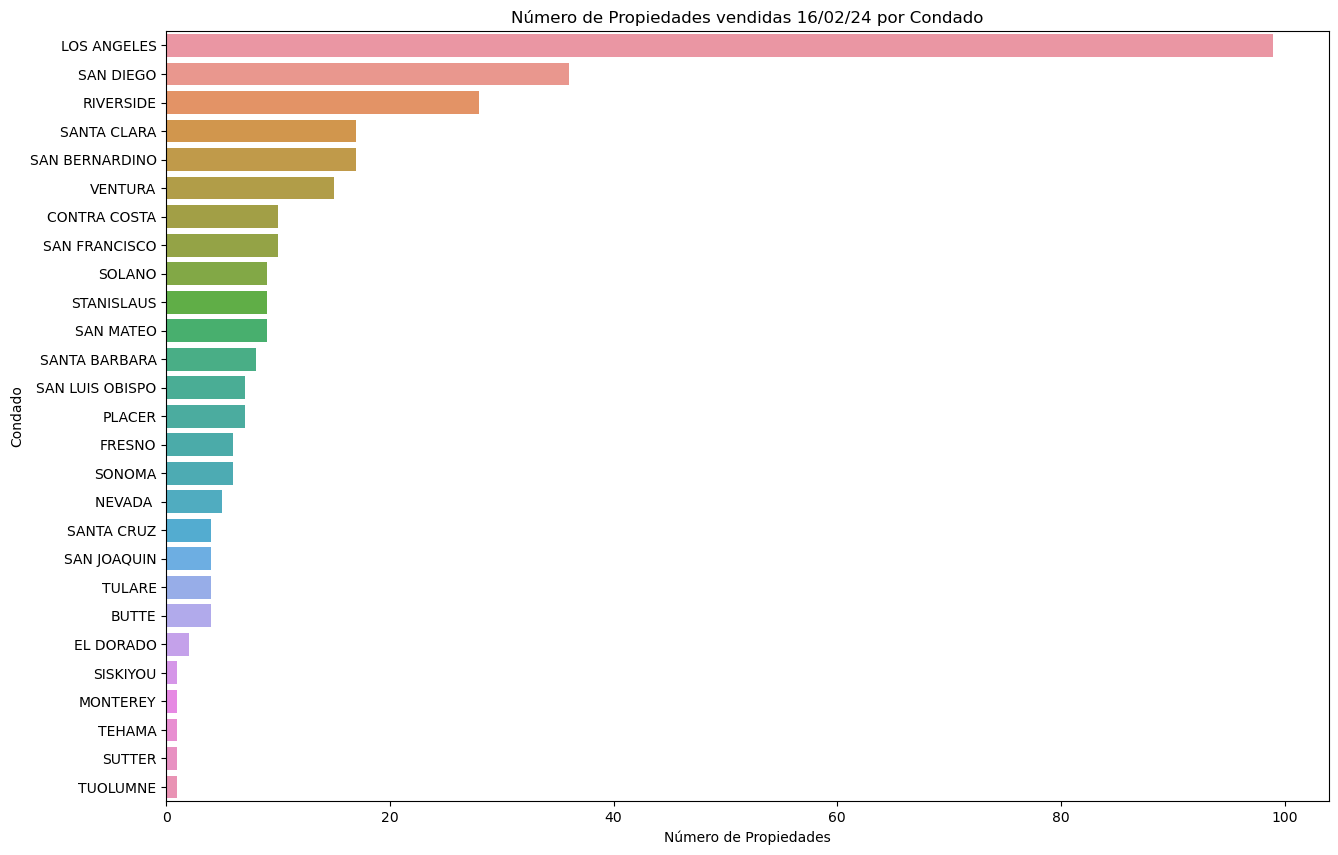

In [20]:
plt.figure(figsize=(15, 10))
sns.countplot(y='COUNTY', data=df_bueno, order = df_bueno['COUNTY'].value_counts().index)
plt.title('Número de Propiedades vendidas 16/02/24 por Condado')
plt.xlabel('Número de Propiedades')
plt.ylabel('Condado')
plt.show()


C:\Users\vsanc\AppData\Local\Temp\ipykernel_8708\3026696954.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  average_price_plot = sns.barplot(x='average_listing_price', y='COUNTY', data=df_bueno, estimator=np.mean, ci=None, order=df_bueno.groupby('COUNTY')['average_listing_price'].mean().sort_values(ascending=False).index)


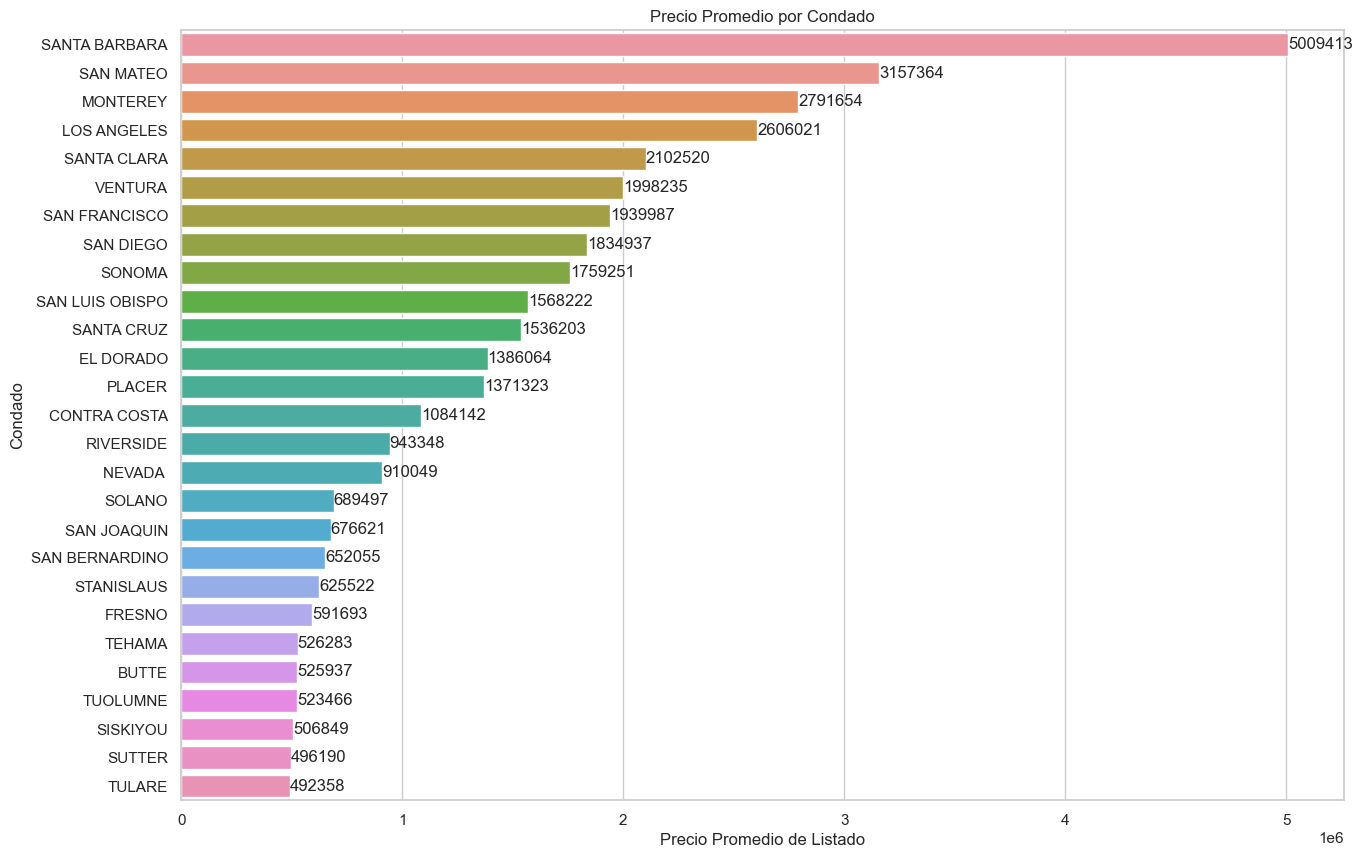

In [21]:
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

# Crea el gráfico de barras para el precio promedio por condado
average_price_plot = sns.barplot(x='average_listing_price', y='COUNTY', data=df_bueno, estimator=np.mean, ci=None, order=df_bueno.groupby('COUNTY')['average_listing_price'].mean().sort_values(ascending=False).index)

# Añade el valor promedio en cada barra
for p in average_price_plot.patches:
    width = p.get_width()    # Obtener el ancho de la barra (el valor promedio en este caso)
    average_price_plot.text(width + 3,  # Posición en x donde se colocará el texto
                            p.get_y() + p.get_height() / 2,  # Posición en y
                            f'{int(width)}',  # Texto a mostrar (valor promedio)
                            ha = 'left',   # Alineación horizontal
                            va = 'center')  # Alineación vertical

plt.title('Precio Promedio por Condado')
plt.xlabel('Precio Promedio de Listado')
plt.ylabel('Condado')
plt.show()


Aqui podemos observar que Santa Barbara tiene un menor volumen de venta de propiedades, es la que tiene el promedio de precio más alto, igual ocurre con San Mateo y Monte Rey.

c:\Users\vsanc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


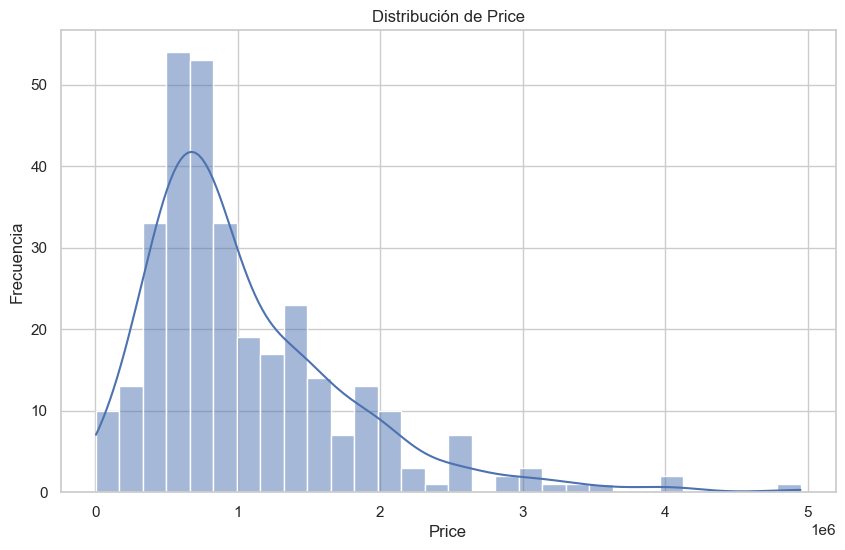

c:\Users\vsanc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


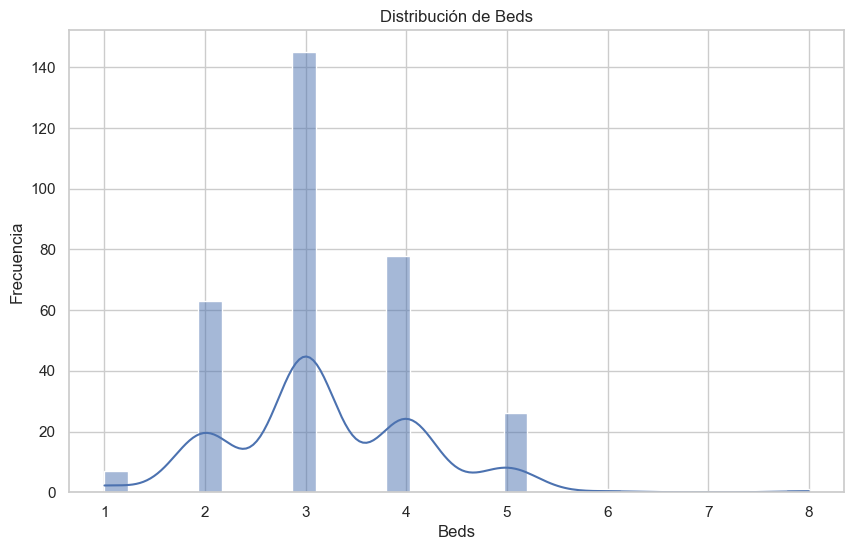

c:\Users\vsanc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


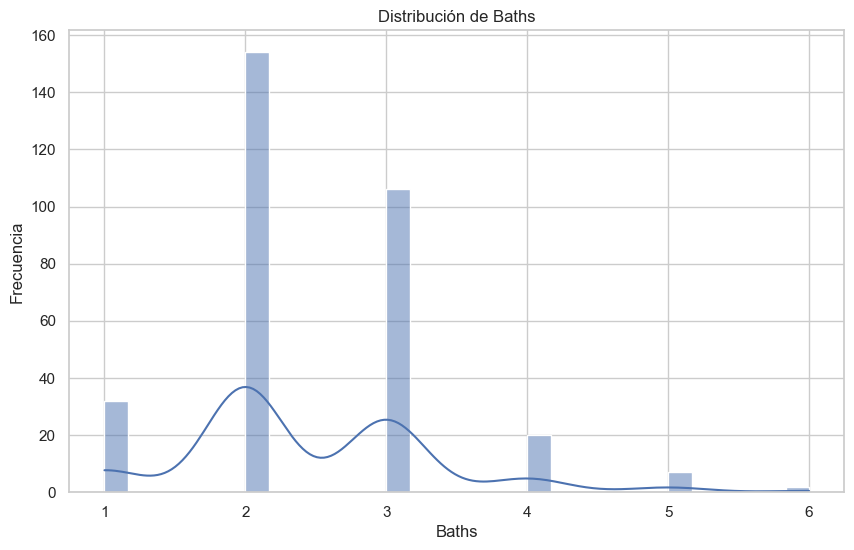

c:\Users\vsanc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


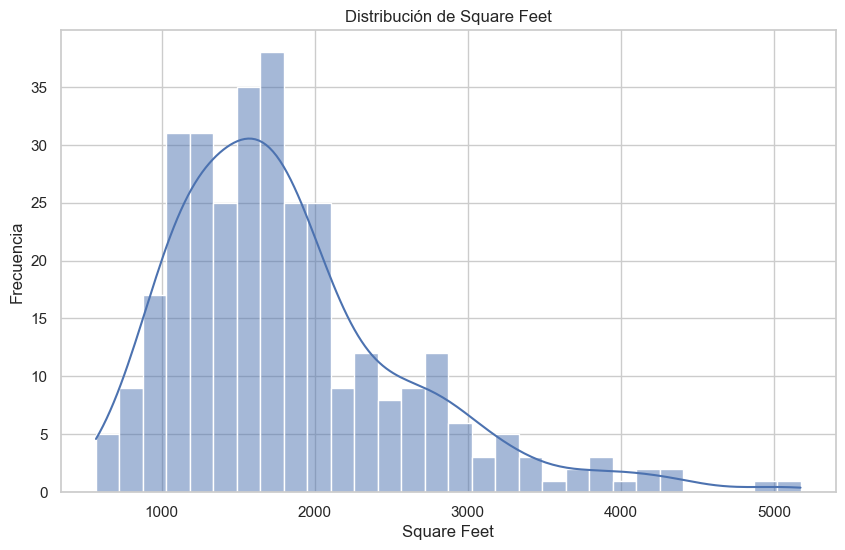

c:\Users\vsanc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


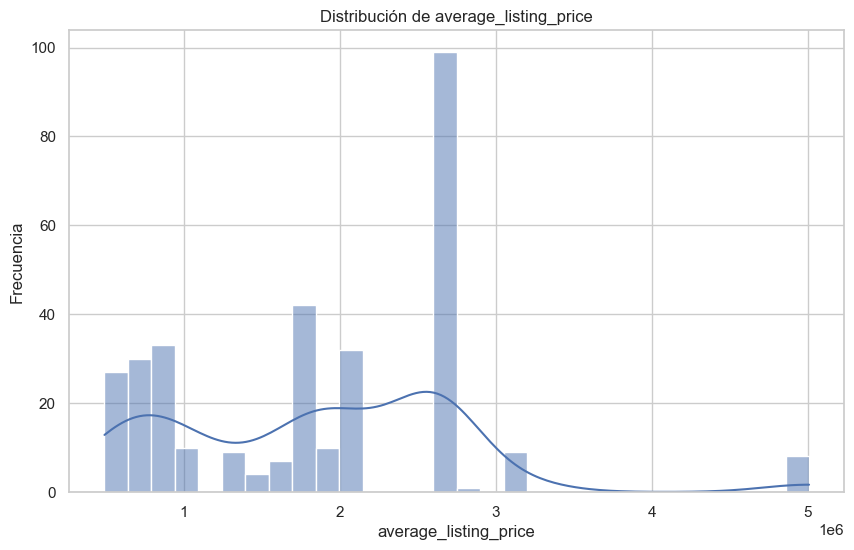

In [22]:
# Lista de columnas numéricas para los cuales quieres generar histogramas
numeric_columns = ['Price', 'Beds', 'Baths', 'Square Feet', 'average_listing_price']

# Genera y muestra un histograma para cada variable numérica
for column in numeric_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_bueno[column], kde=True, bins=30)  # 'kde=True' añade una curva de densidad estimada
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()

## 1: Cargar y Preparar los Datos

In [3]:
df_FINAL = pd.read_csv('df_FINAL.csv')

## 2: Preparar la Función para Mostrar Imágenes

In [4]:
def mostrar_imagenes(df_FINAL, carpeta_imagenes, num_imagenes=6):
    # Asegurarse de que el número de imágenes a mostrar no exceda el tamaño del DataFrame
    num_imagenes = min(num_imagenes, len(df_FINAL))
    
    # Seleccionar aleatoriamente 'num_imagenes' filas del DataFrame
    muestras_df = df_FINAL.sample(n=num_imagenes)
    
    plt.figure(figsize=(15, 10))
    for i, fila in enumerate(muestras_df.itertuples(), start=1):
        ruta_imagen = os.path.join(carpeta_imagenes, f"{fila.id_image}.jpg")
        print(f"Intentando abrir: {ruta_imagen}")  # Imprimir la ruta para depuración
        try:
            imagen = Image.open(ruta_imagen)
            plt.subplot(2, 3, i)
            plt.imshow(imagen)
            plt.title(f"Price: {fila.Price}")
            plt.axis('off')
        except FileNotFoundError:
            print(f"No se pudo abrir: {ruta_imagen}")  # Mensaje si la imagen no se encuentra
    plt.show()



##  3: Mostrar Imágenes

Intentando abrir: C:/Users/vsanc/OneDrive/Escritorio/PROYECTO SMART VALUATION/zillow_images\18015 Hercules St.jpg
Intentando abrir: C:/Users/vsanc/OneDrive/Escritorio/PROYECTO SMART VALUATION/zillow_images\620 Foresthill Ave.jpg
Intentando abrir: C:/Users/vsanc/OneDrive/Escritorio/PROYECTO SMART VALUATION/zillow_images\1953 S Los Robles Ave.jpg
Intentando abrir: C:/Users/vsanc/OneDrive/Escritorio/PROYECTO SMART VALUATION/zillow_images\2419 Ebony St.jpg
Intentando abrir: C:/Users/vsanc/OneDrive/Escritorio/PROYECTO SMART VALUATION/zillow_images\350 Gilmore Rd SPACE 66.jpg


Intentando abrir: C:/Users/vsanc/OneDrive/Escritorio/PROYECTO SMART VALUATION/zillow_images\2232 Daladier Dr.jpg


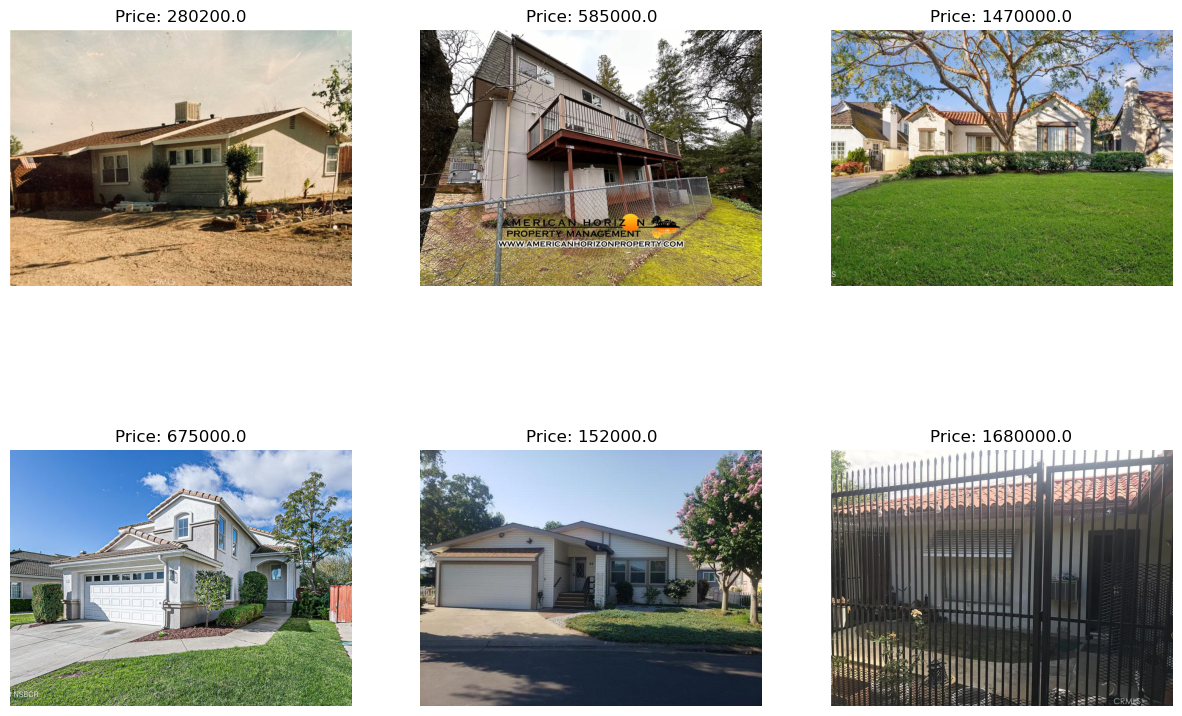

In [7]:
# Especifica la ruta a tu carpeta de imágenes
carpeta_imagenes = 'C:/Users/vsanc/OneDrive/Escritorio/PROYECTO SMART VALUATION/zillow_images'  
# Llama a la función para mostrar imágenes
mostrar_imagenes(df_FINAL, carpeta_imagenes)


## Preprocesamiento de datos tabulares

Dado que los identificadores de las imágenes son cadenas de texto, necesitaremos convertirlos en valores numéricos únicos para poder utilizarlos en nuestro modelo. Una forma común de hacer esto es mediante la codificación de etiquetas, donde cada identificador único se asigna a un valor numérico.

In [8]:

# Crear una instancia de LabelEncoder
label_encoder = LabelEncoder()

# Ajustar y transformar los identificadores de imágenes en valores numéricos
df_FINAL['id_image_encoded'] = label_encoder.fit_transform(df_FINAL['id_image'])

# Obtener los mapeos de las etiquetas originales a los valores numéricos
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [9]:
# Mostrar el mapeo de las etiquetas originales a los valores numéricos
mapping

{'100 Fairvale Ct': 0,
 '100 Independence Ave': 1,
 '1006 Rutledge Ave': 2,
 '10207 Camarillo St': 3,
 '10318 Dalewood Way': 4,
 '1061 Wildwood Rd': 5,
 '10791 Citrus Dr': 6,
 '10847 Sunnybrae Ave': 7,
 '10872 Star Pine Rd': 8,
 '109 Wilson Ave': 9,
 '110 Twins Ct': 10,
 '1111 Yosemite St': 11,
 '11151 Breezy Blvd': 12,
 '1131 Araquipa Ct': 13,
 '1136 Belleza St': 14,
 '114 10th Ave': 15,
 '1143 W 24th St': 16,
 '1152 Richmond St': 17,
 '116 Madrone Ave': 18,
 '1172 Lachman Ln': 19,
 '1177 Countrywood Ln': 20,
 '12433 Kingspine Ave': 21,
 '1255 Navello St': 22,
 '1262 Shady Ln': 23,
 '12703 Softwind Dr': 24,
 '1274 Clarendon St': 25,
 '12923 Droxford St': 26,
 '1306 Rainbow Dr': 27,
 '131 W Oak St': 28,
 '13218 La Jolla Cir UNIT C': 29,
 '1328 Carnell Ct': 30,
 '13308 Skislope Way': 31,
 '13595 Kibbings Rd': 32,
 '1388 Cushendall Dr': 33,
 '139 Spyglass Hill Rd': 34,
 '1401 Cedarwood Dr': 35,
 '14122 Sacramento St': 36,
 '142 S Mount Vernon Ave': 37,
 '1431 Alabama St': 38,
 '14348 Flo

In [10]:
# Seleccionar las características numéricas relevantes
caracteristicas_num = ['Beds', 'Baths', 'Square Feet', 'average_listing_price']


In [11]:
# Lista las variables categóricas relevantes
caracteristicas_cat = ['id_image','Street', 'City', 'COUNTY']

In [12]:
# Escalado de características numéricas
scaler = StandardScaler()
df_FINAL[caracteristicas_num] = scaler.fit_transform(df_FINAL[caracteristicas_num])

In [13]:
# Codificación de variables categóricas usando pd.get_dummies
df_cat_encoded = pd.get_dummies(df_FINAL[caracteristicas_cat], drop_first=True)  # drop_first=True para evitar la trampa de las variables dummy

In [14]:
# Concatenar las características numéricas y categóricas codificadas
X = pd.concat([df_FINAL[caracteristicas_num], df_cat_encoded], axis=1)


In [15]:
# Definir la variable objetivo
y = df_FINAL['Price']

In [16]:
# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Preprocesamiento de imágenes

In [17]:
# Función para cargar y preprocesar imágenes
def cargar_y_preprocesar_imagenes(carpeta_imagenes, ids_imagen):
    imagenes = []
    for id_imagen in ids_imagen:
        ruta_imagen = os.path.join(carpeta_imagenes, f"{id_imagen}.jpg")
        try:
            imagen = Image.open(ruta_imagen)
            imagen = imagen.resize((64, 64))  # Redimensionar a 64x64
            imagen = np.array(imagen) / 255.0  # Normalizar a [0, 1]
            imagenes.append(imagen)
        except FileNotFoundError:
            print(f"No se pudo encontrar o abrir {ruta_imagen}")
    return np.array(imagenes)

In [18]:
# Seleccionar los identificadores de imágenes para los conjuntos de entrenamiento y prueba
ids_imagen_train = df_FINAL.loc[X_train.index, 'id_image']
ids_imagen_test = df_FINAL.loc[X_test.index, 'id_image']

In [19]:
# Cargar y preprocesar las imágenes para conjuntos de entrenamiento y prueba
imagenes_train = cargar_y_preprocesar_imagenes(carpeta_imagenes, ids_imagen_train)
imagenes_test = cargar_y_preprocesar_imagenes(carpeta_imagenes, ids_imagen_test)

No se pudo encontrar o abrir C:/Users/vsanc/OneDrive/Escritorio/PROYECTO SMART VALUATION/zillow_images\162 Tiger Tail Rd.jpg


In [20]:
# Imprimir la forma de los conjuntos de imágenes
print("Forma de imágenes de entrenamiento:", imagenes_train.shape)
print("Forma de imágenes de prueba:", imagenes_test.shape)

Forma de imágenes de entrenamiento: (255, 64, 64, 3)
Forma de imágenes de prueba: (65, 64, 64, 3)


## Construir el modelo de red neuronal

In [22]:
# Definir la arquitectura del modelo CNN
modelo = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1)  # Capa de salida para la predicción del precio
])

# Compilar el modelo
modelo.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Resumen del modelo
modelo.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)       

In [23]:
# Entrenar el modelo con los datos de entrenamiento
historial = modelo.fit(imagenes_train, y_train, epochs=10, batch_size=32, validation_data=(imagenes_test, y_test))


ValueError: Data cardinality is ambiguous:
  x sizes: 255
  y sizes: 256
Make sure all arrays contain the same number of samples.